# Homework 1 - Part B
You are interviewing with Google’s ad team and one of their tasks is predicting the Click Through Rate (CTR) of ads they place on web or mobile properties. Code up a model that predicts the CTR based on Logistic Regression.

---

### Part 1 - Setup and Data Cleanup/Exploration

To start, these are all the libraries I will be using to complete this assignment

In [2]:
# For fast processing of tensors
import torch
import torch.linalg

# Other numerical processing
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Data importing
import pandas as pd

# I initially used sklearn's breast cancer dataset to ensure that my model was performing in the first place
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

This Python notebook assumes that the `test.gz` and `train.gz` files from the click through rate prediction data set can be found in the `./data` folder.

In order to complete this assignment I create a `train_sample.gz` file which is a portion of the full training set so that I do not run out of memory trying to train my model. The bulk of this assignment is completed using `train_sample.gz`.

In [3]:
# Load a portion of the train data into a dataframe
CHUNK_SIZE = 10 ** 6
SAMPLE_SIZE_PER_CHUNK = 10 ** 4
partial_data_sample = pd.DataFrame()

with pd.read_csv("./data/train.gz", compression="gzip", chunksize=CHUNK_SIZE) as reader:
    for chunk in reader:
        data = chunk.sample(SAMPLE_SIZE_PER_CHUNK)
        partial_data_sample = pd.concat([partial_data_sample, data])

# Preprocess the test data
partial_data_sample.to_csv("./data/train_sample.gz", compression="gzip")

I start by using the `pandas` library to load data from the `csv` files (compressed with the gzip format) into `pandas` Dataframes which I can perform some basic data cleaning and exploratory data analysis on. THe C14-C21 classes are still anonymized so I will have to plot these out in order to decide if they are useful or not.

I'm starting with the test set and only part of the train set as currently the full train set is too large for me to load without crashing my environment.

First I will load both the train and test data and list the columns of the train set. The test data I will use later to generate the Kaggle contest submission.

In [5]:
# Load the train and test sets
test_data = pd.read_csv("./data/test.gz", compression="gzip")
train_data = pd.read_csv('./data/train_sample.gz', compression="gzip")

# List the columns
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        410000 non-null  int64  
 1   id                410000 non-null  float64
 2   click             410000 non-null  int64  
 3   hour              410000 non-null  int64  
 4   C1                410000 non-null  int64  
 5   banner_pos        410000 non-null  int64  
 6   site_id           410000 non-null  object 
 7   site_domain       410000 non-null  object 
 8   site_category     410000 non-null  object 
 9   app_id            410000 non-null  object 
 10  app_domain        410000 non-null  object 
 11  app_category      410000 non-null  object 
 12  device_id         410000 non-null  object 
 13  device_ip         410000 non-null  object 
 14  device_model      410000 non-null  object 
 15  device_type       410000 non-null  int64  
 16  device_conn_type  41

I'm going to investigate the non-numeric columns and see if any of them are worth encoding to a numeric format to be able to use in my logistic regressor.

In [6]:
train_data.select_dtypes(include=["object"]).nunique()

site_id            2151
site_domain        2141
site_category        20
app_id             2251
app_domain          155
app_category         26
device_id         66045
device_ip        265868
device_model       4413
dtype: int64

From this `site_category` and `app_category` look the most reasonable to encode. However without some legend or key of app categories and site categories I'm not sure how much information I will be able to derive from these classes or how reliable they will be. If I am not satisfied with my model performance I may try using label encoding to make use of these columns and see if any measurable performance improvement can be derived from using these categories.

In the meanwhile I will plot all the numeric classes and see if any patterns can be deciphered from them. This will help me decide which classes may be most useful for developing and testing a smaller model before constructing the larger model processing more columns.

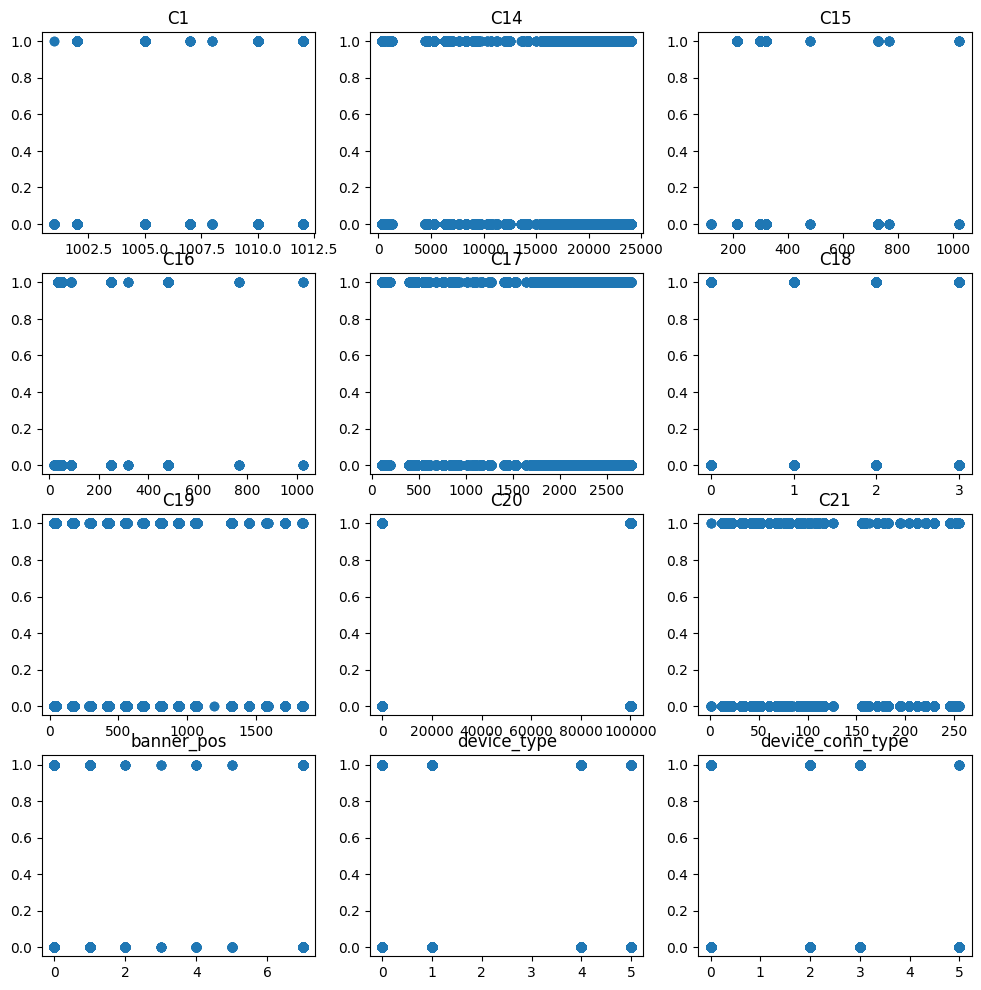

In [7]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

# Used to generate a single labeled plot
def gen_plot(axis, category, data):
    axis.scatter(data[category], data.click)
    axis.set_title(category)

# The layout of plots
cols_organized = [["C1", "C14", "C15"], 
                  ["C16", "C17", "C18"], 
                  ["C19", "C20", "C21"], 
                  ["banner_pos", "device_type", "device_conn_type"]]

# Iterate and plot all my plots
for row in range(4):
    for col in range(3):
        gen_plot(axes[row][col], cols_organized[row][col], train_data)

From initial graphing, none of these classes seem to demonstrate a very clear threshold for each class. For my initial model, `C15` seems to contain the most discrete clusters just looking at the graphs so I may try to construct my model initially using `C15`.

I will also create these plots to investigate the timestamp data. I'm specifically more interested in the month, day, and hour data as things like the holiday season may impact the click through rate of ads.

Text(0.5, 1.0, 'Month')

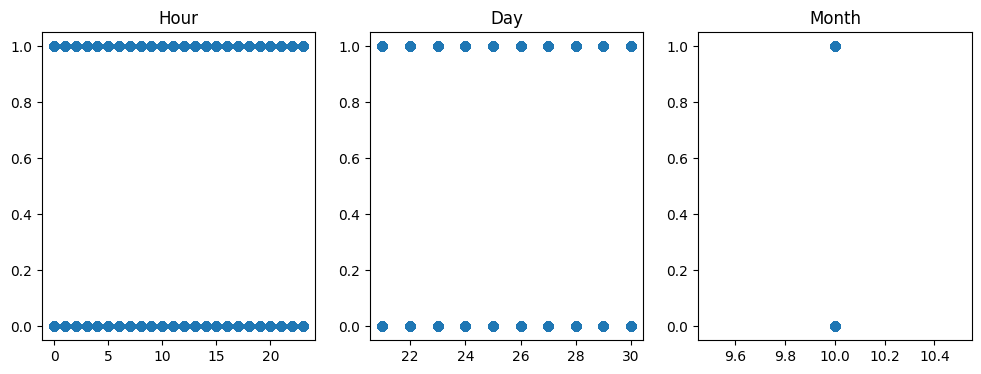

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Since timestamps are formatted as YYMMDDHH I will extract each component using modulus
hour = train_data.hour % 100
day = (train_data.hour - hour) // 100 % 100
month = (train_data.hour - day - hour) // 10000 % 100

# And plot
axes[0].scatter(hour, train_data.click)
axes[0].set_title("Hour")
axes[1].scatter(day, train_data.click)
axes[1].set_title("Day")
axes[2].scatter(month, train_data.click)
axes[2].set_title("Month")

While no pattern can be discerned once again from this initial overview of the dataset, considering that the dataset only contains 10 days worth of data the `hour` column may end up being the most useful so I will keep it around. I may also attempt to use this column for my initial model to see if temporal information helps achieve some degree of accuracy in prediction alongside the `C15` category.

With this I will create the first preprocessing step as a function. This function extracts all of the columns that I may be able to use in my final model, though I will apply a second step to filter the specific columns I want to utilize.

In [15]:
'''
The first preprocessing step for this dataset. Takes a Pandas dataframe, cleans NaN and NULL values, extracts/engineers most useful features
and returns the resulting dataset of the preprocessing step.

train is an arg used to identify if the set being preprocessed is from training data or not, this is necessary as the test data
does not have a click column.
'''
def preprocess(df, train=True):
    # Extract columns I want
    filter_cols = ['id', 'click', 'hour', 'C1', 'banner_pos', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
    if not train:
        filter_cols = filter_cols[0:0] + filter_cols[2:] # Skip click as it does not exist in the test data
    df = df[filter_cols]

    # Remove None and NaN
    df = df.dropna()

    # Extract hour data
    df.hour = df.hour % 100
    
    return df

Now I can clean and display the datasets.

In [18]:
# Clean
train_data = preprocess(train_data)
test_data = preprocess(test_data, False)

# Display
train_data.head(5)

,id,click,hour,C1,banner_pos,C14,C15,C16,C17,C18,C19,C20,C21
0,7.112784e+18,0,3,1005,0,21611,320,50,2480,3,299,100111,61
1,1.733672e+19,0,3,1005,0,21611,320,50,2480,3,299,100111,61
2,1.387031e+18,0,2,1005,0,21647,320,50,2487,1,547,100188,51
3,1.263662e+18,0,5,1005,0,8330,320,50,761,3,175,100075,23
4,1.495655e+19,0,4,1005,0,21665,320,50,2493,3,35,100166,117


My method for creating the logistic regressor involved defining the functions that I will use to train the weights of my logistic regressor and make predictions. To ensure that my code is able to produce a logistic regressor that approaches some optima in training the weights I first use `scikit-learn`'s breast cancer dataset as a toy example. The next section focuses on creating the regression model. I will also define a function to produce the Precision and Recall curve.

### Part 2 - Logistic Regression and SGD Model

The rough overview of my model is as follows:
1. I split the train data into a train and test set and split each set into the input and output classes
2. I preprocess my data into a format that PyTorch can efficiently work with to train my weights
3. I create a vector of 0s with 1 more element than the number of classes I'm going to use as input for my regressor. The final element will be the bias element
4. I pass my training data, initialized weight vector, and vector of ground truths into an SGD function, and define a learning rate and batch size to tune the weights with SGD.

Thus I will define in this section
1. A processing function that operates on Pandas dataframes to produce train and test sets, separate output from input classes, and formats my datasets into values that the model will be ready to work on 
2. A function to compute the gradient of the logistic regression loss function
3. An SGD function to compute the gradient for minibatches of the training data and tune the weights over some number of epochs
4. An evaluation function which produces a confusion matrix given training data, weights, classes, and a classification threshold
5. A function to produce the Precision vs. Recall curve for a given state of the model.

First I must define how I will process data with these functions. Ideally I would like to work with tensors as much as possible to perform computation in bulk and take advantage of PyTorch's matrix computation capabilities.

To do so, I will define $M_{b}$ to be a tensor such that every row of the tensor is a row in the train set with an extra column of $1$ for the bias term. For example suppose my minibatch only has 2 rows and I'm only using two features:
$$
M_{b}=\begin{bmatrix}
x_{12} & x_{11} & 1\\
x_{22} & x_{21} & 1
\end{bmatrix}
$$
In this example, $x_{jk}$ is defined as $j$ being the a row in the set, and $k$ being a feature within that row.

The reason for this is so that I can compute $\hat{\mathbf{y}}$ by multiplying the entire $M_{b}$ matrix by the weight vector $\mathbf{w}$. If $M_{b}\mathbf{w}=\mathbf{\alpha}$ then every element of $\mathbf{\alpha}$ is the result of the dot product between a row of $M_{b}$ and $\mathbf{w}$.

I will write the function to produce this $M_{b}$ given a pandas dataframe containing only the input classes, a series containing only the test class/output class, and a proportion used to split the data

In [ ]:
'''
data must be a dataframe with only the classes we want to work with
target must be a series with only the target class
test_size is 0.25 by default
Returns 4 tensors in the order M_b_train, y_train_vec, M_b_test, y_test_vec
'''
def data_to_tensors(data, target, prop=0.25):
    # Perform the train test split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=prop)

    # Create the train and test vectors with shapes that will behave well with the pipeline later down the line
    y_train_vec = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view((len(y_train), 1))
    y_test_vec = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view((len(y_test), 1))

    X_train_mat = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    M_b_train = torch.cat((X_train_mat, torch.ones((X_train_mat.shape[0], 1), dtype=torch.float32)), dim=1)

    X_test_mat = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    M_b_test = torch.cat((X_test_mat, torch.ones((X_test_mat.shape[0], 1), dtype=torch.float32)), dim=1)

    return (M_b_train, M_b_test, y_train_vec, y_test_vec)

For logistic regression, classification is performed using the sigmoid activation function. The **Sigmoid** function is defined as follows:
$$
\sigma(\alpha)=\frac{1}{1+\text{exp}(-\alpha)}
$$
To make a prediction with this function, we compute the following:
$$
\sigma(\textbf{w}^{T} \textbf{x})
$$
Where $\textbf{w}$ represents the weights of the activation we tune using SGD, and $\textbf{x}$ represents a feature vector. The sigmoid function itself is implemented by the PyTorch library in `torch.sigmoid`. This is why I wanted to set up my data so that $\textbf{w}^{T} \textbf{x}$ can be computed simply in code. My loss function will need me to compute several $\hat{y}_{i}$ so I would prefer to be able to compute every prediction at once with a matrix-vector multiplication.


First we need to define not just the loss function, but specifically the gradient of the loss function. For a binary classifier defined by a single sigmoid activation, the gradient of the binary cross entropy loss function is:
$$
\nabla_{w}L=\sum_{i=1}^{m}(\hat{y}_{i}-y_{i})\textbf{x}_{i}
$$
If we're using stochastic gradient descent we will perform a summation over a mini batch as opposed to the entire $m$, thus:
$$
\nabla_{w}L=\sum_{i=1}^{m_{b}}(\hat{y}_{i}-y_{i})\textbf{x}_{i}
$$
where we define $m_{b}$ to be some mini batch derived from the entire train set.

My gradient compute function should be able to accept any sized dataset/batch. The function below implements the computation of the gradient of the loss function under the assumption that the data has been processed with `data_to_tensors` and we are receiving PyTorch tensors as input.

To compute this gradient I will
1. Compute $M_{b}\mathbf{w}=\mathbf{\alpha}$ to produce a vector of $\mathbf{w}^{T} \mathbf{x}$.
2. Apply the `sigmoid` activation to $\mathbf{\alpha}$ element-wise to compute a vector of every $\hat{y}_{i}$ since $\sigma(\alpha_{i})=\hat{y}_{i}$
3. Compute $\hat{\mathbf{y}}-\mathbf{y}$ where $\mathbf{y}$ is the vector of the ground truth values
4. Multiply the result to $M_{b}$ elementwise since each row of $M_{b}$ is $\mathbf{x}_{i}$ with an extra $1$ to incorporate the bias term correctly
5. Take the sum of all the rows of the resultant matrix to perform the summation

In [20]:
'''
If n is the number of classes, and m is the number of rows, then
w is an (n + 1) x 1 tensor with the weights (and bias) of the model
M_b is an m x (n + 1) tensor representing the data with all the input classes and an extra column of ones for easy computation of y-hat
classes is an m x 1 tensor with the ground truth values
'''
def logistic_gradient(w, M_b, classes):
    # Compute all y_hat
    y_hat = torch.matmul(M_b, w)
    y_hat = torch.sigmoid(y_hat)

    # Compute the difference
    err = y_hat - classes

    # Multiple element wise across M_b
    sum_terms = err * M_b

    # Perform the summation
    grad = torch.sum(sum_terms, dim=0).view((w.shape[0], 1))
    return grad


The formula, generically, for **Gradient Descent**, is as follows:
$$
\mathbf{w}_{k+1}=\mathbf{w}_{k}-\eta\nabla_{\mathbf{w}}L(\mathbf{w}_{k})
$$
**Stochastic Gradient Descent** is simply an extension of this using only minibatches or portions of the train set. Thus, the **Stochastic Gradient Descent** algorithm must take the following parameters
1. The weights (bias included) to be stepped/optimized for: $\mathbf{w}$
2. The training data, processed into $M_{b}$ and $\mathbf{y}$
3. The number of iterations or epochs
4. The hyperparameter $\eta$ or the learning rate
5. The hyperparameter $b$ or the batch size

In [52]:
def sgd(w, M_b, y, epochs, learn_rate, batch_size, print_rate=-1):
    for epoch in range(epochs):
        for i in range(0, M_b.shape[0], batch_size):
            # Select a mini-batch of 'batch_size'
            batch_indices = np.random.choice(M_b.shape[0], batch_size, replace=False)
            xi = M_b[batch_indices]
            yi = y[batch_indices]

            g = logistic_gradient(w, xi, yi)

            w = w - learn_rate * g
        
        if print_rate > 0 and epoch % print_rate == 0:
            print("Epoch", epoch, "completed")
    
    return w

To compute a confusion matrix, we simply have to compute $\sigma(M_{b}\mathbf{w})=\hat{\mathbf{y}}$ using $M_{b}$ generated from the training set instead, set a threshold to decide if the prediction is positive or negative based on the result probability, and then count the number of true positives, true negatives, false positives, and false negatives.

In [91]:
'''
Returns in the order
0 - True Positive
1 - False Positive
2 - False Negative
3 - True Negative
'''
def comp_conf_matrix(w, M_b_test, y_test, threshold):
    # Compute all y_hat
    y_hat = torch.matmul(M_b_test, w)
    y_hat = torch.sigmoid(y_hat)

    # Initialize values
    fp = 0
    tp = 0
    fn = 0
    tn = 0

    # Count
    for i in range(y_hat.shape[0]):
        pred = 1 if y_hat[i] > threshold else 0

        if y_test[i] == 1 and pred == 1:
            tp += 1
        elif y_test[i] == 0 and pred == 0:
            tn += 1
        elif y_test[i] == 1 and pred == 0:
            fn += 1
        else:
            fp += 1
    
    # Return
    return (tp, fp, fn, tn)

Then to compute the precision-recall curve, I just have to compute precision and recall for different thresholds between 1 and 0

In [94]:
def gen_prec_recall(w, M_b_test, y_test, points):
    precision = []
    recall = []
    counter = 0
    for i in np.linspace(0.0, 0.01, num=points):
        # Compute the confusion matrix
        tp, fp, fn, tn = comp_conf_matrix(w, M_b_test, y_test, i)
        
        p = []
        r = []
        try:
            p = [tp / (tp + fp)]
            r = [tp / (tp + fn)]
        except:
            continue

        precision = precision + p
        recall = recall + r
    
    precision = np.array(precision, dtype=np.float32)
    recall = np.array(recall, dtype=np.float32)
    
    return (precision, recall)

### Part 2.5 - Toy Example

To verify that I can generate a well performing model, I test using the scikit learn breast cancer dataset

In [76]:
# Load and preprocess data
data, target = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = data_to_tensors(data, target)

# Create and test performance before training
w = torch.zeros((X_train.shape[1], 1), dtype=torch.float32)
tp, fp, fn, tn = comp_conf_matrix(w, X_test, y_test, 0.5)
print(tp, fp, fn, tn)

# Print metrics
print("Accuracy:", (tp + tn) / (tp + fp + tn + fn))

torch.Size([426, 31])
0 0 93 50
Accuracy: 0.34965034965034963


Now I will train the weights `w`

In [77]:
# Train
w = sgd(w, X_train, y_train, 10000, 1e-3, 50, print_rate=1000)

# Predict
tp, fp, fn, tn = comp_conf_matrix(w, X_test, y_test, 0.5)
print(tp, fp, fn, tn)
print("Accuracy:", (tp + tn) / (tp + fp + tn + fn))

Epoch 0 completed
Epoch 1000 completed
Epoch 2000 completed
Epoch 3000 completed
Epoch 4000 completed
Epoch 5000 completed
Epoch 6000 completed
Epoch 7000 completed
Epoch 8000 completed
Epoch 9000 completed
86 5 7 45
Accuracy: 0.916083916083916


As you can see, the accuracy has improved by training the weights, demonstrating that these functions as defined are effective. I'll also test my precision vs recall function here.

In [95]:
precision, recall = gen_prec_recall(w, X_test, y_test, 100)

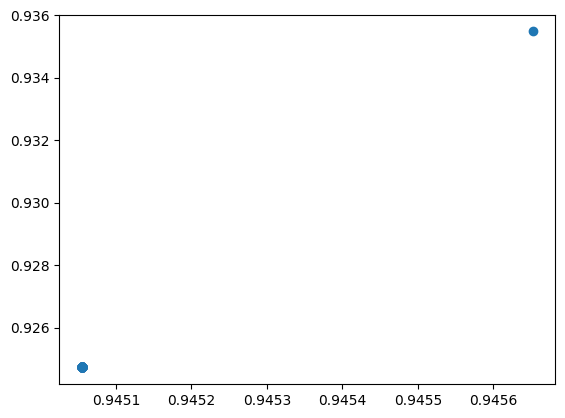

In [90]:
plt.scatter(precision, recall)
plt.show()

In the case above, the model seems to be pretty consistent in its predictions, so with all the columns of data we seem to be lacking uncertainty. We have two data points so it's hard to extrapolate a curve from this but given the values I can infer this model is quite performant, and there's a certain threshold for the thresholds where while we'd be making a tradeoff between The following model attempts to introduce more uncertainty by reducing the number of columns to work with.

torch.Size([426, 3])
Epoch 0 completed
Epoch 1000 completed
Epoch 2000 completed
Epoch 3000 completed
Epoch 4000 completed
Epoch 5000 completed
Epoch 6000 completed
Epoch 7000 completed
Epoch 8000 completed
Epoch 9000 completed
86 5 7 45
Accuracy: 0.916083916083916


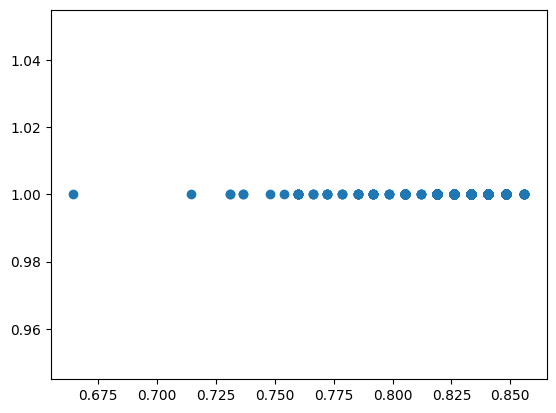

In [101]:
# Load and preprocess data
data, target = load_breast_cancer(return_X_y=True, as_frame=True)
data = data[['mean radius', 'mean texture']]
X_train, X_test, y_train, y_test = data_to_tensors(data, target)

w = torch.zeros((X_train.shape[1], 1), dtype=torch.float32)
w = sgd(w, X_train, y_train, 10000, 1e-3, 50, print_rate=1000)
print(tp, fp, fn, tn)
print("Accuracy:", (tp + tn) / (tp + fp + tn + fn))

precision, recall = gen_prec_recall(w, X_test, y_test, 1000)
plt.scatter(precision, recall)
plt.show()

Interestingly, this led to variation in the precision, but not the recall, so our false positive and true negative counts are the counts that are varying.

### Part 3 - Simple Model

The following code tests the pipeline as defined above with a portion of the train data using only `C15` and `hour` columns

In [66]:
# Convert to tensors
model_data = train_data[['C15', 'hour']]
model_target = train_data[['click']].squeeze()
X_train, X_test, y_train, y_test = data_to_tensors(model_data, model_target, 0.2)

# Create weights
w = torch.zeros((X_train.shape[1], 1), dtype=torch.float32)
print("Before Training")
tp, fp, fn, tn = comp_conf_matrix(w, X_test, y_test, 0.5)
print(tp, fp, fn, tn)
print("Accuracy:", (tp + tn) / (tp + fp + tn + fn))

# Train
print()
w = sgd(w, X_train, y_train, 10000, 1e-3, 50000, print_rate=1000)
print()

# Predict
print("\nAfter Training")
tp, fp, fn, tn = comp_conf_matrix(w, X_test, y_test, 0.5)
print(tp, fp, fn, tn)
print("Accuracy:", (tp + tn) / (tp + fp + tn + fn))

torch.Size([328000, 3])
Before Training
0 0 13779 68221
Accuracy: 0.8319634146341464

Epoch 0 completed
Epoch 1000 completed
Epoch 2000 completed
Epoch 3000 completed
Epoch 4000 completed
Epoch 5000 completed
Epoch 6000 completed
Epoch 7000 completed
Epoch 8000 completed
Epoch 9000 completed


After Training
0 0 13779 68221
Accuracy: 0.8319634146341464


Our accuracy for the same threshold of `0.5` has not improved, however we can still attempt to plot a precision vs recall curve for the given weights

In [69]:
precision, recall = gen_prec_recall(w, X_test, y_test, 100)

In [72]:
len(precision)

0

Unfortunately since given the current weights I am always predicting negative I will not be able to compute a precision so I cannot generate a precision vs recall curve. The solution to this problem is either to run my model over more epochs, or include more columns, which I will try in a later section in this notebook.

### Part 4 - GPU Acceleration

I rewrite my logistic gradient to run on the GPU

In [74]:
def logistic_gradient_gpu(w, M_b, classes):
    # Move everything to the GPU
    device = torch.device("cuda")
    w = w.to(device)
    M_b = M_b.to(device)
    classes = classes.to(device)

    # Compute all y_hat
    y_hat = torch.matmul(M_b, w)
    y_hat = torch.sigmoid(y_hat)

    # Compute the difference
    err = y_hat - classes

    # Multiple element wise across M_b
    sum_terms = err * M_b

    # Perform the summation
    grad = torch.sum(sum_terms, dim=0).view((w.shape[0], 1))

    # Return to CPU
    grad = grad.to("cpu")
    return grad

def sgd_gpu(w, M_b, y, epochs, learn_rate, batch_size, print_rate=-1):
    for epoch in range(epochs):
        for i in range(0, M_b.shape[0], batch_size):
            # Select a mini-batch of 'batch_size'
            batch_indices = np.random.choice(M_b.shape[0], batch_size, replace=False)
            xi = M_b[batch_indices]
            yi = y[batch_indices]

            g = logistic_gradient_gpu(w, xi, yi)

            w = w - learn_rate * g
        
        if print_rate > 0 and epoch % print_rate == 0:
            print("Epoch", epoch, "completed")
    
    return w

The following code uses the GPU version instead

In [ ]:
# Convert to tensors
model_data = train_data[['C15', 'hour']]
model_target = train_data[['click']].squeeze()
X_train, X_test, y_train, y_test = data_to_tensors(model_data, model_target, 0.2)

# Create weights
w = torch.zeros((X_train.shape[1], 1), dtype=torch.float32)
print("Before Training")
tp, fp, fn, tn = comp_conf_matrix(w, X_test, y_test, 0.5)
print(tp, fp, fn, tn)
print("Accuracy:", (tp + tn) / (tp + fp + tn + fn))

# Train
print()
w = sgd_gpu(w, X_train, y_train, 10000, 1e-3, 50000, print_rate=1000)
print()

# Predict
print("\nAfter Training")
tp, fp, fn, tn = comp_conf_matrix(w, X_test, y_test, 0.5)
print(tp, fp, fn, tn)
print("Accuracy:", (tp + tn) / (tp + fp + tn + fn))

I am unable to run this code on my current device, as my CUDA compute capability is 5.0 which is no longer supported by the version of PyTorch used by this environment.

### Part 5 - All Columns

This time I will try performing the regression task with all of the columns

In [102]:
# Convert to tensors
model_data = train_data[['hour', 'C1', 'banner_pos', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']]
model_target = train_data[['click']].squeeze()
X_train, X_test, y_train, y_test = data_to_tensors(model_data, model_target, 0.2)

# Create weights
w = torch.zeros((X_train.shape[1], 1), dtype=torch.float32)
print("Before Training")
tp, fp, fn, tn = comp_conf_matrix(w, X_test, y_test, 0.5)
print(tp, fp, fn, tn)
print("Accuracy:", (tp + tn) / (tp + fp + tn + fn))

# Train
print()
w = sgd(w, X_train, y_train, 10000, 1e-3, 100000, print_rate=1000)
print()

# Predict
print("\nAfter Training")
tp, fp, fn, tn = comp_conf_matrix(w, X_test, y_test, 0.5)
print(tp, fp, fn, tn)
print("Accuracy:", (tp + tn) / (tp + fp + tn + fn))

torch.Size([328000, 12])
Before Training
0 0 13937 68063
Accuracy: 0.8300365853658537

Epoch 0 completed
Epoch 1000 completed
Epoch 2000 completed
Epoch 3000 completed
Epoch 4000 completed
Epoch 5000 completed
Epoch 6000 completed
Epoch 7000 completed
Epoch 8000 completed
Epoch 9000 completed


After Training
7395 30093 6542 37970
Accuracy: 0.5532317073170732


Alternatively

In [ ]:
# Convert to tensors
model_data = train_data[['hour', 'C1', 'banner_pos', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']]
model_target = train_data[['click']].squeeze()
X_train, X_test, y_train, y_test = data_to_tensors(model_data, model_target, 0.2)

# Create weights
w = torch.zeros((X_train.shape[1], 1), dtype=torch.float32)
print("Before Training")
tp, fp, fn, tn = comp_conf_matrix(w, X_test, y_test, 0.5)
print(tp, fp, fn, tn)
print("Accuracy:", (tp + tn) / (tp + fp + tn + fn))

# Train
print()
w = sgd_gpu(w, X_train, y_train, 10000, 1e-3, 100000, print_rate=1000)
print()

# Predict
print("\nAfter Training")
tp, fp, fn, tn = comp_conf_matrix(w, X_test, y_test, 0.5)
print(tp, fp, fn, tn)
print("Accuracy:", (tp + tn) / (tp + fp + tn + fn))